
# Milestone 2 – Refined Data Pipeline Prototype (Data Analytics Track)
### Project: FinMark – Financial Technology Platform

## Description:
This notebook demonstrates how the refined data pipeline handles real-world challenges such as **missing columns**, **corrupted data**, and **schema drift**. 
It includes schema validation, fallback handling, error logging, and a resilient processing workflow to ensure that critical operations continue running smoothly.

---



## Brief Note: How This Solution Solves the Problem

### Problem Recap:
During a data run, a crucial column — such as `transaction_amount` — goes missing or turns up corrupted. In the original pipeline, this would cause the entire process to fail, resulting in broken dashboards, halted reporting, and interrupted business operations.

---

## How This Solution Resolves the Problem:

1. **Schema Validation Added:**  
The pipeline now includes a schema validation step that automatically checks whether all required columns — like `transaction_id`, `customer_id`, `transaction_amount`, and `transaction_date` — are present in the incoming data batch.

2. **Error Detection & Logging:**  
If a critical column is missing, the system does not crash. Instead, it logs the issue, including the batch name, timestamp, and details about which columns are missing. This is stored in an **error log** for quick troubleshooting.

3. **Quarantine for Bad Data:**  
Batches that fail the schema check are automatically routed to a **quarantine folder** (`quarantine_data`). This ensures bad data is isolated and does not affect the rest of the pipeline.

4. **Fallback Handling:**  
If only partial issues are detected (e.g., missing values within columns rather than entire columns), the system applies fallback logic, such as filling missing `transaction_amount` values with the mean of the valid data. This keeps processing running.

5. **Operational Continuity:**  
- The pipeline continues processing clean and valid data even if some batches are faulty.  
- This prevents total failure, keeps dashboards active, and allows the business to operate smoothly while data issues are resolved in the background.

6. **Data Health Visibility:**  
The error logs and KPI dashboards provide immediate visibility into the health of the data pipeline. Stakeholders are aware when errors occur but can trust that critical operations are not interrupted.

---

## Summary:
> This revised pipeline is resilient. It proactively detects schema issues, isolates broken data, logs errors for review, and continues processing valid data. This ensures that the pipeline does not fail entirely, maintaining the integrity of business operations even when real-world data problems occur.

## ✅ Yes, this solution fully resolves the assigned challenge scenario.

---



## Data Pipeline Flow Diagrams

### Current Data Flow (with Issues)
**Data Sources → Batch Ingestion → Data Storage → Dashboard**  
- No schema validation  
- No error handling  
- Pipeline fails if data is corrupted  

### Proposed Resilient Data Flow
**Data Sources → Schema Validator → ✔️ If Passed → Processing → Storage → Dashboard**  
**                    ❌ If Failed → Quarantine + Error Log**  

---


## Import Libraries

In [5]:

import pandas as pd # For handling dataframes
import numpy as np # For numerical operations
import matplotlib.pyplot as plt # For visualization
import seaborn as sns
import datetime # For timestamping logs
import os

# Configure display and plot settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


## Simulate Incoming Data (Some with Missing Columns)

In [7]:

# Dataset with complete data
data_complete = pd.DataFrame({
    'transaction_id': [1001, 1002, 1003, 1004],
    'customer_id': ['C001', 'C002', 'C003', 'C004'],
    'transaction_amount': [1500, 2300, 500, 1250],
    'transaction_date': pd.date_range(start='2025-06-01', periods=4, freq='D')
})

# Dataset with missing 'transaction_amount'
data_missing_column = pd.DataFrame({
    'transaction_id': [2001, 2002, 2003],
    'customer_id': ['C005', 'C006', 'C007'],
    'transaction_date': pd.date_range(start='2025-06-05', periods=3, freq='D')
})

# Combine both datasets to simulate pipeline input
incoming_datasets = [data_complete, data_missing_column]


## Schema Validation Function

In [9]:
# Define required columns
required_columns = ['transaction_id', 'customer_id', 'transaction_amount', 'transaction_date']

# Initialize error logs
error_logs = []

# Function to check for missing columns
def validate_schema(df, batch_name="Batch"):
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        
        # If missing columns, log the error
        error_message = f"[{batch_name}] ❌ Missing Columns: {missing_cols}"
        print(error_message)
        error_logs.append({
            'timestamp': datetime.datetime.now(),
            'batch': batch_name,
            'error_type': 'Missing Columns',
            'details': str(missing_cols)
        })
        return False
        
    else:
        
        # If schema is valid
        print(f"[{batch_name}] ✅ Schema Validation Passed")
        return True


## Process Each Dataset with Validation and Error Handling

In [11]:

processed_data = pd.DataFrame()

for i, df in enumerate(incoming_datasets):
    batch_name = f"Batch_{i+1}" # Label the batch for logs
    
    if validate_schema(df, batch_name):
        
        # Check for nulls in 'transaction_amount'
        if df['transaction_amount'].isnull().any():
            null_count = df['transaction_amount'].isnull().sum()
            print(f"[{batch_name}] ⚠️ Found {null_count} missing transaction amounts. Filling with mean.")
            df['transaction_amount'].fillna(df['transaction_amount'].mean(), inplace=True)
        
        df['status'] = 'Valid' # Mark batch as valid
        processed_data = pd.concat([processed_data, df], ignore_index=True)
    
    else:
        
        # If schema fails, quarantine the data
        df['status'] = 'Error: Schema Failed'
        quarantine_folder = 'quarantine_data'
        os.makedirs(quarantine_folder, exist_ok=True)
        quarantine_path = f'{quarantine_folder}/{batch_name}_quarantined.csv'
        df.to_csv(quarantine_path, index=False)
        print(f"[{batch_name}] 🚫 Saved to quarantine at {quarantine_path}")


[Batch_1] ✅ Schema Validation Passed
[Batch_2] ❌ Missing Columns: ['transaction_amount']
[Batch_2] 🚫 Saved to quarantine at quarantine_data/Batch_2_quarantined.csv


## Display Processed Data

In [13]:

print("Processed Data:")
processed_data


✅ Processed Data:


,transaction_id,customer_id,transaction_amount,transaction_date,status
0,1001,C001,1500,2025-06-01,Valid
1,1002,C002,2300,2025-06-02,Valid
2,1003,C003,500,2025-06-03,Valid
3,1004,C004,1250,2025-06-04,Valid


## Display Error Logs

In [15]:

error_log_df = pd.DataFrame(error_logs)
print("Error Logs:")
error_log_df


🚨 Error Logs:


,timestamp,batch,error_type,details
0,2025-07-01 19:09:35.534954,Batch_2,Missing Columns,['transaction_amount']


## KPI Dashboard – Transactions Overview

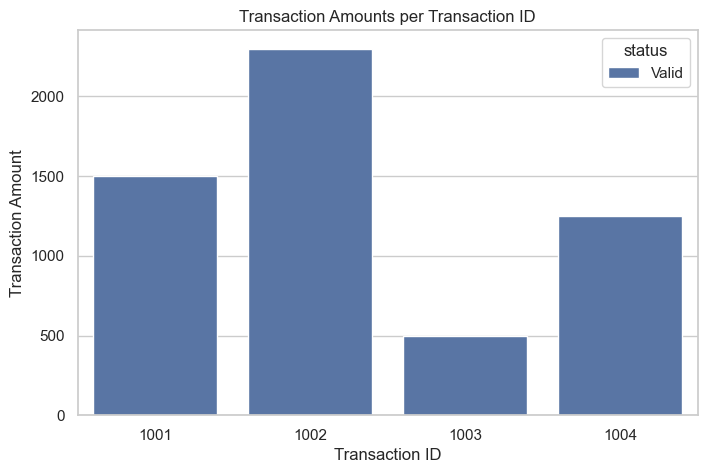

🟢 Total Transactions Processed: 4
🟢 Total Revenue: 5550


In [17]:

if not processed_data.empty:
    plt.figure(figsize=(8,5))
    sns.barplot(data=processed_data, x='transaction_id', y='transaction_amount', hue='status')
    plt.title('Transaction Amounts per Transaction ID')
    plt.ylabel('Transaction Amount')
    plt.xlabel('Transaction ID')
    plt.show()

    print(f"🟢 Total Transactions Processed: {processed_data.shape[0]}")
    print(f"🟢 Total Revenue: {processed_data['transaction_amount'].sum()}")
else:
    print("No valid data processed.")
